Load in the data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
path = "/content/drive/My Drive/Coursework/SDSC8007/Homework/HW1"
os.chdir(path)
# I load the data from my Google Drive, Please change the path to your own directory

## Data Preprocessing

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [4]:
# data set
train = pd.read_csv('HW1.train.csv')
test = pd.read_csv('HW1.test.csv')

In [5]:
# drop id and 
train = train.iloc[:,41:]
test = test.iloc[:,41:]

In [ ]:
cols = list(train.columns[:18]) + list(train.columns[:18]+['_rate']) + ['test_positive_true'] 
train_set = pd.DataFrame(columns = cols)

In [ ]:
# adding the original data
phase_one = train.iloc[:,:18]
phase_two = train.iloc[:,18:36]
phase_two.columns = train.columns[:18]
test_phase = test.iloc[:,:18]

# contact dataset
original_data_m1 = pd.concat([phase_one, phase_two], axis=0, ignore_index = True)
original_data = pd.concat([original_data_m1, test_phase], axis=0, ignore_index = True)

In [ ]:
# adding improvement rate data
cols = list(train.columns[:18] + '_rate') + ['test_positive_true'] 
# calculate percentage
rate_set = pd.DataFrame(columns = cols)

# phase 1
for idx in train.index:
    sample = {}
    for i in list(range(18)):
        sample[cols[i]] = train.iloc[idx,i+18]/train.iloc[idx,i] - 1
    sample[cols[18]] = train.iloc[idx,17+18]
    rate_set = rate_set.append(pd.Series(sample), ignore_index = True)

# phase 2
for idx in train.index:
    sample = {}
    for i in list(range(18)):
        sample[cols[i]] = train.iloc[idx,i+36]/train.iloc[idx,i+18] - 1
    sample[cols[18]] = train.iloc[idx,35+18]
    rate_set = rate_set.append(pd.Series(sample), ignore_index = True)

In [ ]:
for idx in test.index:
    sample = {}
    for i in list(range(18)):
        sample[cols[i]] = test.iloc[idx,i+18]/test.iloc[idx,i] - 1
    sample[cols[18]] = test.iloc[idx,17+18]
    rate_set = rate_set.append(pd.Series(sample), ignore_index = True)

In [ ]:
# contact the original data and rate set
train_set = pd.concat([original_data, rate_set], axis=1)

In [ ]:
# # save the engineered datast
# train_set.to_csv('train_set_engineered.csv', index = False)

In [111]:
# train_set = pd.read_csv('train_set_engineered.csv')

In [112]:
# split validation and train
train_set, val_set = train_test_split(train_set, test_size=0.01, random_state=42)

In [114]:
# the objective of our task is to predict the change in percentage from the first survey to the next
# split X and y
y = train_set['tested_positive_rate']
X = train_set.drop(['tested_positive_rate','test_positive_true'], axis = 1)

In [115]:
# normalization
## get the column mean and column std
# need to standardized inputs
X_scaled = scale(X)
y_scaled = scale(y)
X_train_mean = np.mean(X, axis = 0)
X_train_std = np.std(X, axis = 0)
y_train_mean = np.mean(y)
y_train_std = np.std(y)

## Network Setup

In [116]:
from tensorflow import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
from keras.models import load_model

# set seed
np.random.seed(42)
tf.random.set_seed(42)

In [117]:
config = {
    'learning_rate': 0.0003,
    'epochs': 1500,
    'batch_size': 128,
    'patience': 150
}

In [118]:
model = Sequential()
model.add(Dense(512, input_dim = X_scaled.shape[1], activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.1))
model.add(Dense(64, activation = "relu"))
model.add(Dense(1, activation = "linear"))

In [119]:
opt = keras.optimizers.Adam(learning_rate=config['learning_rate'])
model.compile(loss = "mean_squared_error", optimizer = opt, 
              metrics = ["mean_squared_error"])

In [120]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=config['patience'], verbose = 1)
mc = keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

train_history = model.fit(X_scaled, y_scaled, batch_size = config['batch_size'], callbacks = [callback, mc], 
          validation_split = 0.2, epochs = config['epochs'], verbose = 1)

Epoch 1/1500
25/29 [========================>.....] - ETA: 0s - loss: 0.9702 - mean_squared_error: 0.9702
Epoch 00001: val_loss improved from inf to 0.98137, saving model to best_model.h5
29/29 [==============================] - 1s 13ms/step - loss: 0.9708 - mean_squared_error: 0.9708 - val_loss: 0.9814 - val_mean_squared_error: 0.9814
Epoch 2/1500
25/29 [========================>.....] - ETA: 0s - loss: 0.9007 - mean_squared_error: 0.9007
Epoch 00002: val_loss improved from 0.98137 to 0.93712, saving model to best_model.h5
29/29 [==============================] - 0s 9ms/step - loss: 0.9116 - mean_squared_error: 0.9116 - val_loss: 0.9371 - val_mean_squared_error: 0.9371
Epoch 3/1500
26/29 [=========================>....] - ETA: 0s - loss: 0.8888 - mean_squared_error: 0.8888
Epoch 00003: val_loss improved from 0.93712 to 0.89695, saving model to best_model.h5
29/29 [==============================] - 0s 9ms/step - loss: 0.8664 - mean_squared_error: 0.8664 - val_loss: 0.8970 - val_mean_sq

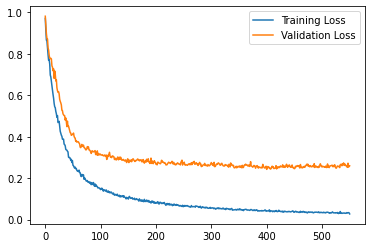

In [122]:
# learning curve
plt.figure()
plt.plot(train_history.history["loss"], label = "Training Loss")
plt.plot(train_history.history["val_loss"], label = "Validation Loss")
plt.legend()

In [123]:
# load the best model
model = load_model('best_model.h5')

## Validation

In [124]:
# split X and scale
X_val = val_set.drop(['tested_positive_rate', 'test_positive_true'], axis = 1)
X_val_scaled = (X_val - X_train_mean)/X_train_std

# predict
y_val_pred_scaled = model.predict(X_val_scaled)
y_val_pred = y_val_pred_scaled*y_train_std + y_train_mean

# get the target
y_val_target = [float((x+1)*y) for x, y in zip(y_val_pred, val_set['tested_positive'])]

In [125]:
mean_squared_error(y_val_target, val_set['test_positive_true'], squared = False)

0.6166955545808142

Text(0, 0.5, 'Actual Percentage')

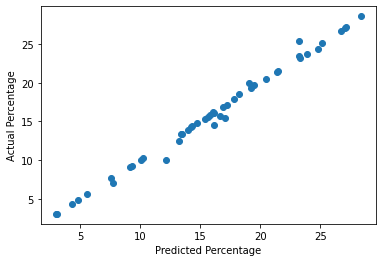

In [126]:
# plot actual vs. predicted
plt.scatter(x = y_val_target, y = val_set['test_positive_true'])
plt.xlabel("Predicted Percentage")
plt.ylabel("Actual Percentage")

## Test

In [127]:
# generate test sample
original_data = test.iloc[:,18:36]
original_data.columns = train.columns[:18]

In [128]:
# adding improvement rate data
cols = list(train.columns[:17] + '_rate') 
# calculate percentage
rate_set = pd.DataFrame(columns = cols)

# phase 2
for idx in test.index:
    sample = {}
    for i in list(range(17)):
        sample[cols[i]] = test.iloc[idx,i+36]/test.iloc[idx,i+18] - 1

    rate_set = rate_set.append(pd.Series(sample), ignore_index = True)

In [129]:
# contact the original data and rate set
X_test = pd.concat([original_data, rate_set], axis=1)

In [130]:
# predict
# scale
X_test_scaled = (X_test - X_train_mean)/X_train_std

# predict
y_test_pred_scaled = model.predict(X_test_scaled)
y_test_pred = y_test_pred_scaled*y_train_std + y_train_mean

# get the target
y_test_target = [float((x+1)*y) for x,y in zip(y_test_pred, X_test['tested_positive'])]

In [131]:
pred = pd.DataFrame(data = {'id': list(range(650)), 'tested_positive': y_test_target}, columns = ['id', 'tested_positive'])

In [132]:
pred.to_csv('prediction_hw1_team12.csv', index = False)